In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# To read file

In [2]:
File = pd.read_csv(r'C:\Users\rohishah\Desktop\ML_Hackathon\predict_stores.csv')
File.columns
File['pop_2009'] = File['pop_2009']/1000
File['per_capita_09'] = File['per_capita_09']/1000

# Feature & target Selection

In [3]:
selected_features = ['pop_2009','per_capita_09']
target = ["PCH_GROC_09_14"]

# Subset of data frame

In [4]:
Stores_data_frame = File[['pop_2009','RECFAC09','PCT_LACCESS_POP10',
                     'METRO13','per_capita_09','PCT_LACCESS_LOWI10',
                     'PCT_LACCESS_HHNV10','FFR09','FSR09',"PCH_GROC_09_14"]]
Stores_data_frame = Stores_data_frame.fillna(0.0)

In [5]:
Stores_data_frame.head()

,pop_2009,RECFAC09,PCT_LACCESS_POP10,METRO13,per_capita_09,PCT_LACCESS_LOWI10,PCT_LACCESS_HHNV10,FFR09,FSR09,PCH_GROC_09_14
0,2.0,0,33.3,0,47.3,11.0,0.4,1,3,False
1,0.7,0,100.0,0,43.5,39.9,5.3,0,2,False
2,2346.4,179,20.0,1,39.1,8.0,1.4,1837,1554,True
3,295.6,24,24.7,1,32.8,6.2,1.2,202,201,False
4,31.4,3,3.4,0,31.5,1.1,2.1,20,27,False


In [6]:
def preprocess_features(Stores_data_frame):
    selected_featur = Stores_data_frame[selected_features]
    processed_features = selected_featur.copy()
     # Create a synthetic feature.
    return processed_features

In [7]:
def preprocess_targets(Stores_data_frame):
    output_targets = pd.DataFrame()
    output_targets[target] =Stores_data_frame[target] 
    return output_targets

# Spit data into traning & validation 

In [8]:
training_examples = preprocess_features(Stores_data_frame.head(2000))
training_targets = preprocess_targets(Stores_data_frame.head(2000))
validation_examples = preprocess_features(Stores_data_frame.tail(1086))
validation_targets = preprocess_targets(Stores_data_frame.tail(1086))

In [9]:
training_examples.head()

,pop_2009,per_capita_09
0,2.0,47.3
1,0.7,43.5
2,2346.4,39.1
3,295.6,32.8
4,31.4,31.5


In [10]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [11]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    my_optimizer,
    hidden_units):
    
    periods = 10
    steps_per_period = steps / periods
  
  # Create a linear classifier object.
    my_optimizer = my_optimizer
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
    linear_classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer,
     hidden_units = hidden_units)
  
  # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["PCH_GROC_09_14"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["PCH_GROC_09_14"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print ("Training model...")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
        
        linear_classifier.train(input_fn=training_input_fn,
                                steps=steps_per_period)
       # Take a break and compute predictions.
        
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        # Occasionally print the current loss.
        print(period, training_log_loss)
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
   
    print ("Model training finished.")
  
  # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

# gradient descent optimizer

Training model...
0 1.29373316303
1 0.872198962264
2 1.14737109413
3 0.67730757914
4 0.657736259409
5 0.674121249315
6 0.676413336352
7 0.696871896077
8 0.581282265914
9 0.585140089853
Model training finished.


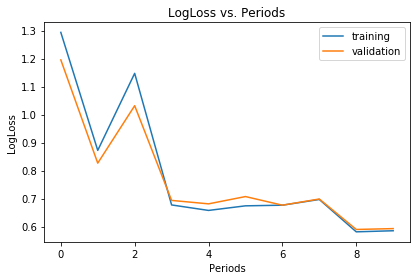

In [13]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01),
    hidden_units=[10,10])

In [14]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print(evaluation_metrics['auc'])
print(evaluation_metrics['accuracy'])
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

0.680829
0.735727


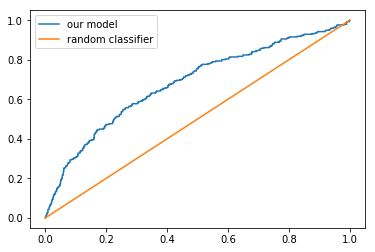

In [15]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

# Print prediction: to check model predicts different values & not constant value

In [16]:
counter = 1
for items in validation_probabilities:
    counter = counter + 1
    if counter > 10:
        break
    print(items)

0.164826
0.102956
0.217938
0.441551
0.242807
0.387496
0.0797325
0.0865169
0.0981973


# Adam optimizer

Training model...
0 1.57373738079
1 2.2090661269
2 1.39365770644
3 0.688951700821
4 0.824152272512
5 0.616048513221
6 0.869587224272
7 0.646592210863
8 0.718881845436
9 0.59032942378
Model training finished.


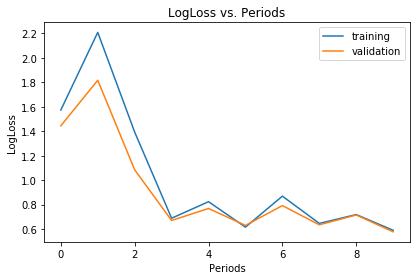

In [17]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.AdamOptimizer(learning_rate=0.01),
    hidden_units=[10,10])

In [18]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print(evaluation_metrics['auc'])
print(evaluation_metrics['accuracy'])
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

0.681658
0.72744


In [19]:
counter = 1
for items in validation_probabilities:
    counter = counter + 1
    if counter > 10:
        break
    print(items)

0.127458
0.0799786
0.209169
0.412203
0.238918
0.412203
0.0671793
0.0650684
0.0864116


# Normalized data : Method - Linear scalar

In [20]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def normalize_linear_scale(examples_dataframe):
    processed_features = pd.DataFrame()
    processed_features["pop_2009"] = linear_scale(examples_dataframe["pop_2009"])
    processed_features["per_capita_09"] = linear_scale(examples_dataframe["per_capita_09"])
    return processed_features

In [21]:
normalized_dataframe = normalize_linear_scale(preprocess_features(Stores_data_frame))
nor_training_examples = preprocess_features(normalized_dataframe.head(2000))
nor_validation_examples = preprocess_features(normalized_dataframe.tail(1086))

# adam Optimizer with linear scalar

Training model...
0 0.591671231657
1 0.588956627861
2 0.592373932295
3 0.654423039645
4 0.58288053406
5 0.585836105973
6 0.587443446144
7 0.628636170711
8 0.603499194831
9 0.5858816652
Model training finished.


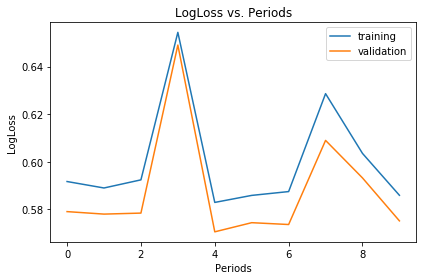

In [22]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    training_examples=nor_training_examples,
    training_targets=training_targets,
    validation_examples=nor_validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.AdamOptimizer(learning_rate=0.01),
    hidden_units=[10,10])

In [23]:
predict_validation_input_fn = lambda: my_input_fn(nor_validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print(evaluation_metrics['auc'])
print(evaluation_metrics['accuracy'])

0.59301
0.733886


In [24]:
nor_validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
nor_validation_probabilitie = np.array([item['probabilities'][1] for item in nor_validation_probabilities])

In [25]:
counter = 1
for items in nor_validation_probabilitie:
    counter = counter + 1
    if counter > 10:
        break
    print(items)

0.274095
0.294693
0.30844
0.312716
0.294983
0.316865
0.29991
0.314644
0.281915


# gradient descent with linear scalar

Training model...
0 0.591161469981
1 0.620206016518
2 0.591162273481
3 0.590263577789
4 0.591890040204
5 0.594180027291
6 0.588651898578
7 0.588518325657
8 0.589245005906
9 0.598477493934
Model training finished.


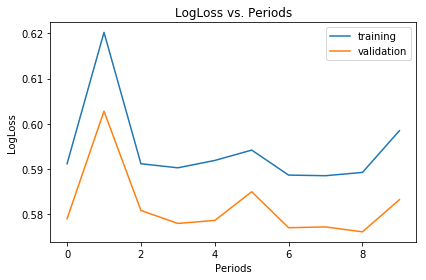

In [26]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    training_examples=nor_training_examples,
    training_targets=training_targets,
    validation_examples=nor_validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01),
    hidden_units=[10,10])

In [27]:
predict_validation_input_fn = lambda: my_input_fn(nor_validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print(evaluation_metrics['auc'])
print(evaluation_metrics['accuracy'])

0.72928178

# Normalized data : Method - Log

In [28]:
def log_normalize(series):
    return series.apply(lambda x:math.log(x+1.0))

def normalize_log(examples_dataframe):
    processed_features = pd.DataFrame()
    processed_features["pop_2009"] = log_normalize(examples_dataframe["pop_2009"])
    processed_features["per_capita_09"] = log_normalize(examples_dataframe["per_capita_09"])
    return processed_features

In [29]:
log_normalized_dataframe = normalize_log(preprocess_features(Stores_data_frame))
nor_log_training_examples = preprocess_features(log_normalized_dataframe.head(2000))
nor_log_validation_examples = preprocess_features(log_normalized_dataframe.tail(1086))

# adam optimizer with log normalized data

Training model...
0 0.578125541314
1 0.578645838276
2 0.546918752618
3 0.547736923136
4 0.554792490024
5 0.548861514818
6 0.561908121668
7 0.54666702491
8 0.585122094302
9 0.545502548903
Model training finished.


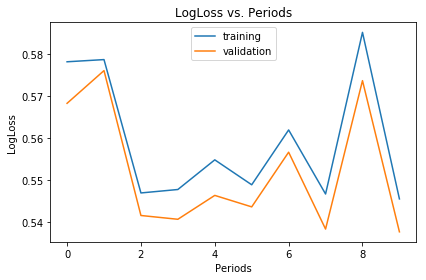

In [30]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    training_examples=nor_log_training_examples,
    training_targets=training_targets,
    validation_examples=nor_log_validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.AdamOptimizer(learning_rate=0.01),
    hidden_units=[10,10])

In [31]:
predict_validation_input_fn = lambda: my_input_fn(nor_log_validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print(evaluation_metrics['auc'])
print(evaluation_metrics['accuracy'])

0.691554
0.754144


# gradient descent with log normalized data

Training model...
0 0.642544199556
1 0.57619861646
2 0.565313759062
3 0.545377465118
4 0.545641182709
5 0.55039687055
6 0.551557327334
7 0.564647063183
8 0.546714637771
9 0.554807812706
Model training finished.


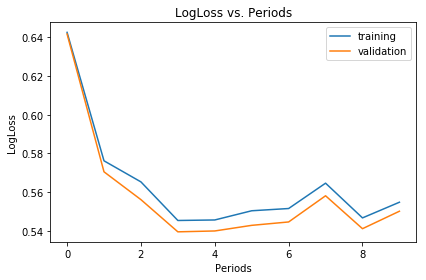

In [32]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    training_examples=nor_log_training_examples,
    training_targets=training_targets,
    validation_examples=nor_log_validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01),
    hidden_units=[10,10])

In [33]:
predict_validation_input_fn = lambda: my_input_fn(nor_log_validation_examples, 
                                                    validation_targets["PCH_GROC_09_14"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
print(evaluation_metrics['auc'])
print(evaluation_metrics['accuracy'])

0.692931
0.74954
